# Basic Cell Clustering Using 100Kb Bins

## Content

Here we go through the basic steps to perform cell clustering using genome non-overlapping 100Kb bins as features.
We start from raw methylation base count data stored in MCDS format.
This format can be used to quickly evaluate cell-type composition in a single-cell methylome dataset
(e.g., the dataset from a single experiment).

### Dataset used in this notebook
- Adult (age P56) male mouse brain primary motor cortex (MOp) snmC-seq2 data from {cite}`Liu2021`.

## Input
- MCDS files (contains chrom100k dim)
- Cell metadata

## Output
- Cell-by-100kb-bin AnnData with embedding coordinates and cluster labels.

## Import

In [2]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, log_scale
from ALLCools.plot import *

## Parameters

In [3]:
# change this to the path to your metadata
metadata_path = '../../data/Brain/snmC-seq2/HIP.CellMetadata.csv.gz'

# Basic filtering parameters. 
# These are suggesting values, cutoff maybe different for different tissue and sequencing depths.
# To determine each cutoff more appropriately, one need to plot the distribution of each metric.
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalReads'  # Name may change
mccc_cutoff = 0.03
mccc_col_name = 'mCCCFrac'  # Name may change
mch_cutoff = 0.2
mch_col_name = 'mCHFrac'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

# change this to the paths to your MCDS files, 
# ALLCools.MCDS can handle multiple MCDS files automatically
mcds_path_list = [
    '../../data/Brain/snmC-seq2/8E_190711.mcds',
    '../../data/Brain/snmC-seq2/8E_190716.mcds',
    '../../data/Brain/snmC-seq2/8J_190711.mcds',
    '../../data/Brain/snmC-seq2/8J_190716.mcds',
    '../../data/Brain/snmC-seq2/9H_190212.mcds',
    '../../data/Brain/snmC-seq2/9H_190219.mcds',
    '../../data/Brain/snmC-seq2/9J_190212.mcds',
    '../../data/Brain/snmC-seq2/9J_190219.mcds',
    '../../data/Brain/snmC-seq2/10E_190625.mcds',
    '../../data/Brain/snmC-seq2/10E_190627.mcds',
    '../../data/Brain/snmC-seq2/10F_190625.mcds',
    '../../data/Brain/snmC-seq2/10F_190627.mcds',
    '../../data/Brain/snmC-seq2/11E_190214.mcds',
    '../../data/Brain/snmC-seq2/11E_190305.mcds',
    '../../data/Brain/snmC-seq2/11F_190214.mcds',
    '../../data/Brain/snmC-seq2/11F_190305.mcds'
]

# Dimension name used to do clustering
# This corresponding to AnnData .obs and .var
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

# feature cov cutoffs
min_cov = 500
max_cov = 3000

# Regions to remove during the clustering analysis
# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be download from https://github.com/Boyle-Lab/Blacklist/
black_list_path = '../../data/genome/mm10-blacklist.v2.bed.gz'
black_list_fraction = 0.2
exclude_chromosome = ['chrM', 'chrY']

# load to memory or not
load = True

# HVF
mch_pattern = 'CHN'
mcg_pattern = 'CGN'
n_top_feature = 20000

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

## Load Cell Metadata

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 16985 cells


AllcPath  mCCCFrac  \
10E_M_0    /gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...  0.008198   
10E_M_1    /gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...  0.006019   
10E_M_10   /gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...  0.006569   
10E_M_101  /gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...  0.006353   
10E_M_102  /gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...  0.005409   

            mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  InputReads  \
10E_M_0    0.822633    0.821166  0.041640    0.033718   1626504.0     4407752   
10E_M_1    0.743035    0.741479  0.024127    0.018218   2009998.0     5524084   
10E_M_10   0.750172    0.748520  0.027665    0.021235   1383636.0     3455260   
10E_M_101  0.760898    0.759369  0.026547    0.020323   2474670.0     7245482   
10E_M_102  0.752980    0.751637  0.019497    0.014164   2430290.0     7004754   

           MappedReads DissectionRegion  BamFilteringRate  MappingRate  \
10E_M_0      2892347.0              10E          0.562347     0.656195   
10E_M_1      3657352.0              10E          0.549577     0.662074   
10E_M_10     2172987.0              10E          0.636744     0.628892   
10E_M_101    4778768.0              10E          0.517847     0.659551   
10E_M_102    4609570.0              10E          0.527227     0.658063   

                       Plate  Col384  Row384  FANSDate  Slice      Sample  
10E_M_0    CEMBA190625-10E-1       0       0    190625     10  10E_190625  
10E_M_1    CEMBA190625-10E-1       0       1    190625     10  10E_190625  
10E_M_10   CEMBA190625-10E-1      19       0    190625     10  10E_190625  
10E_M_101  CEMBA190625-10E-1      18       3    190625     10  10E_190625  
10E_M_102  CEMBA190625-10E-1      19       2    190625     10  10E_190625

## Filter Cells

In [5]:
judge = (metadata[mapping_rate_col_name] > mapping_rate_cutoff) & \
        (metadata[final_reads_col_name] > final_reads_cutoff) & \
        (metadata[mccc_col_name] < mccc_cutoff) & \
        (metadata[mch_col_name] < mch_cutoff) & \
        (metadata[mcg_col_name] > mcg_cutoff)

metadata = metadata[judge].copy()
print(f'{metadata.shape[0]} cells passed filtering')

16985 cells passed filtering


In [6]:
# Save
# metadata.to_csv('Brain.CellMetadata.PassQC.csv.gz')

## Load MCDS

In [7]:
mcds = MCDS.open(
    mcds_path_list, 
    obs_dim='cell', 
    use_obs=metadata.index  # MCDS contains all cells, this will select cells that passed filtering 
)
total_feature = mcds.get_index(var_dim).size
mcds

Open MCDS with netcdf4 engine.


<xarray.MCDS>
Dimensions:              (mc_type: 2, cell: 16985, count_type: 2, chrom100k: 27269, geneslop2k: 55487)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * cell                 (cell) object '8E_M_10' '8E_M_100' ... '11F_M_3042'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
  * geneslop2k           (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSM...
    geneslop2k_chrom     (geneslop2k) object dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_start     (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_end       (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
Data variables:
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(437, 27269, 1, 2), meta=np.ndarray>
    geneslop2k_da        (cell, geneslop2k, mc_type, count_type) uint32 dask.array<chunksize=(146, 55487, 1, 2), meta=np.ndarray>

In [8]:
# you can add the cell metadata into MCDS
mcds.add_cell_metadata(metadata)

## Filter Features

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


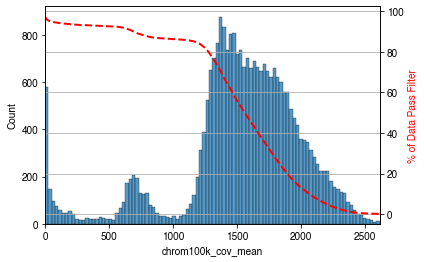

In [9]:
mcds.add_feature_cov_mean(var_dim=var_dim)

We saw three parts here with coverages from low to high, including:
1. Low coverage regions
2. chrX regions, because this dataset from male mouse brain
3. Other autosomal regions

In [10]:
# filter by coverage - based on the distribution above
mcds = mcds.filter_feature_by_cov_mean(
    var_dim=var_dim,
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

# remove blacklist regions
mcds = mcds.remove_black_list_region(
    var_dim,
    black_list_path,
    f=black_list_fraction  # Features having overlap > f with any black list region will be removed.
)

# remove chromosomes
mcds = mcds.remove_chromosome(var_dim, exclude_chromosome)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25242 chrom100k 92.6%
1189 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.
20 chrom100k features in ['chrM', 'chrY'] removed.


## Calculate Feature mC Fractions

In [11]:
mcds.add_mc_frac(
    var_dim=var_dim, 
    normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

# load only the mC fraction matrix into memory so following steps is faster
# Only load into memory when you memory size is enough to handle your dataset
if load and (mcds.get_index(obs_dim).size < 20000):
    mcds[f'{var_dim}_da_frac'].load()

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


The RuntimeWarning is expected (due to cov == 0). You can ignore it.

## Select Highly Variable Features (HVF)

### mCH HVF

In [12]:
mch_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mch_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=True)

Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24045
Highly Variable Feature:  20000 (83.2%)


### mCG HVF

In [13]:
mcg_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mcg_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=True)

Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24045
Highly Variable Feature:  20000 (83.2%)


## Get cell-by-feature mC fraction AnnData

In [14]:
mch_adata = mcds.get_adata(mc_type=mch_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mch_adata

AnnData object with n_obs × n_vars = 16985 × 20000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

In [15]:
mcg_adata = mcds.get_adata(mc_type=mcg_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mcg_adata

AnnData object with n_obs × n_vars = 16985 × 20000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

## Scale

In [16]:
log_scale(mch_adata)

StandardScaler(with_mean=False)

In [17]:
log_scale(mcg_adata)

StandardScaler(with_mean=False)

## PCA

### mCH PCA

32 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 50) to (16985, 32)
Red axis labels are used PCs


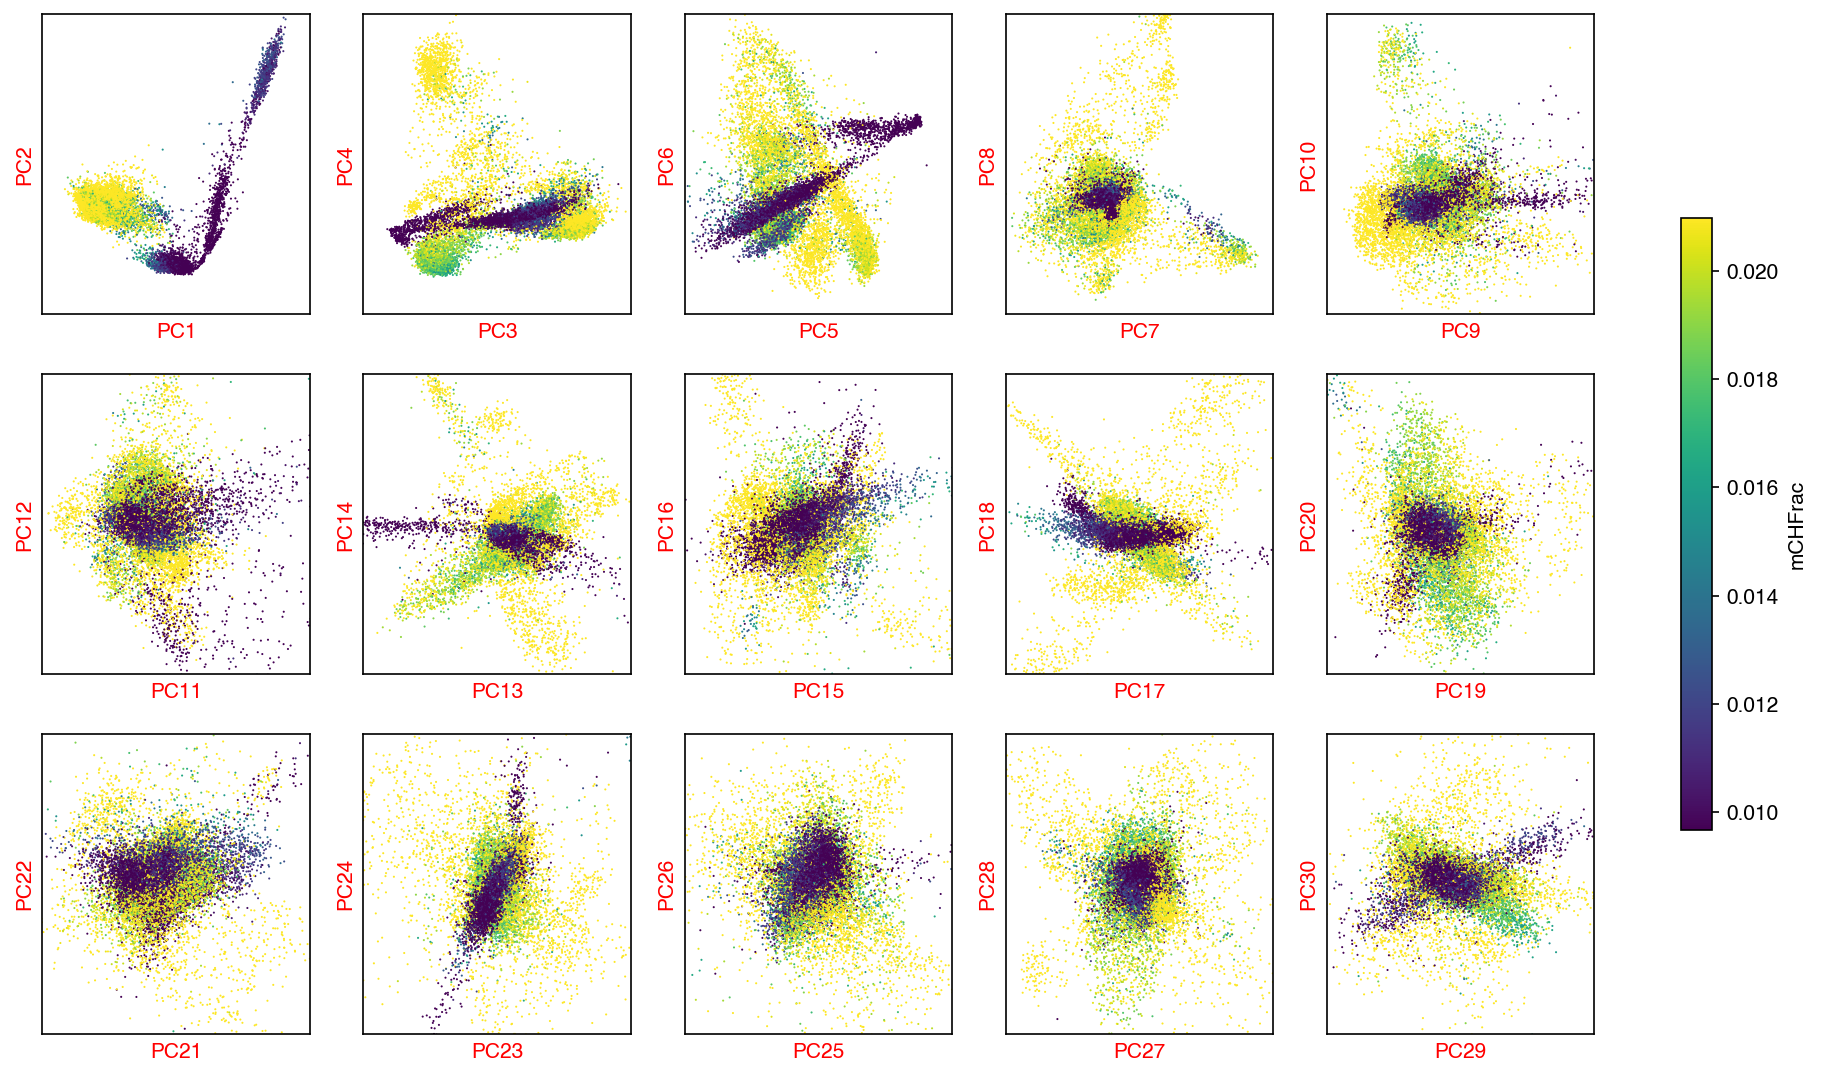

In [18]:
sc.tl.pca(mch_adata)
ch_n_components = significant_pc_test(mch_adata)
fig, axes = plot_decomp_scatters(mch_adata,
                                 n_components=ch_n_components,
                                 hue=mch_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

### mCG PCA

23 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 50) to (16985, 23)
Red axis labels are used PCs


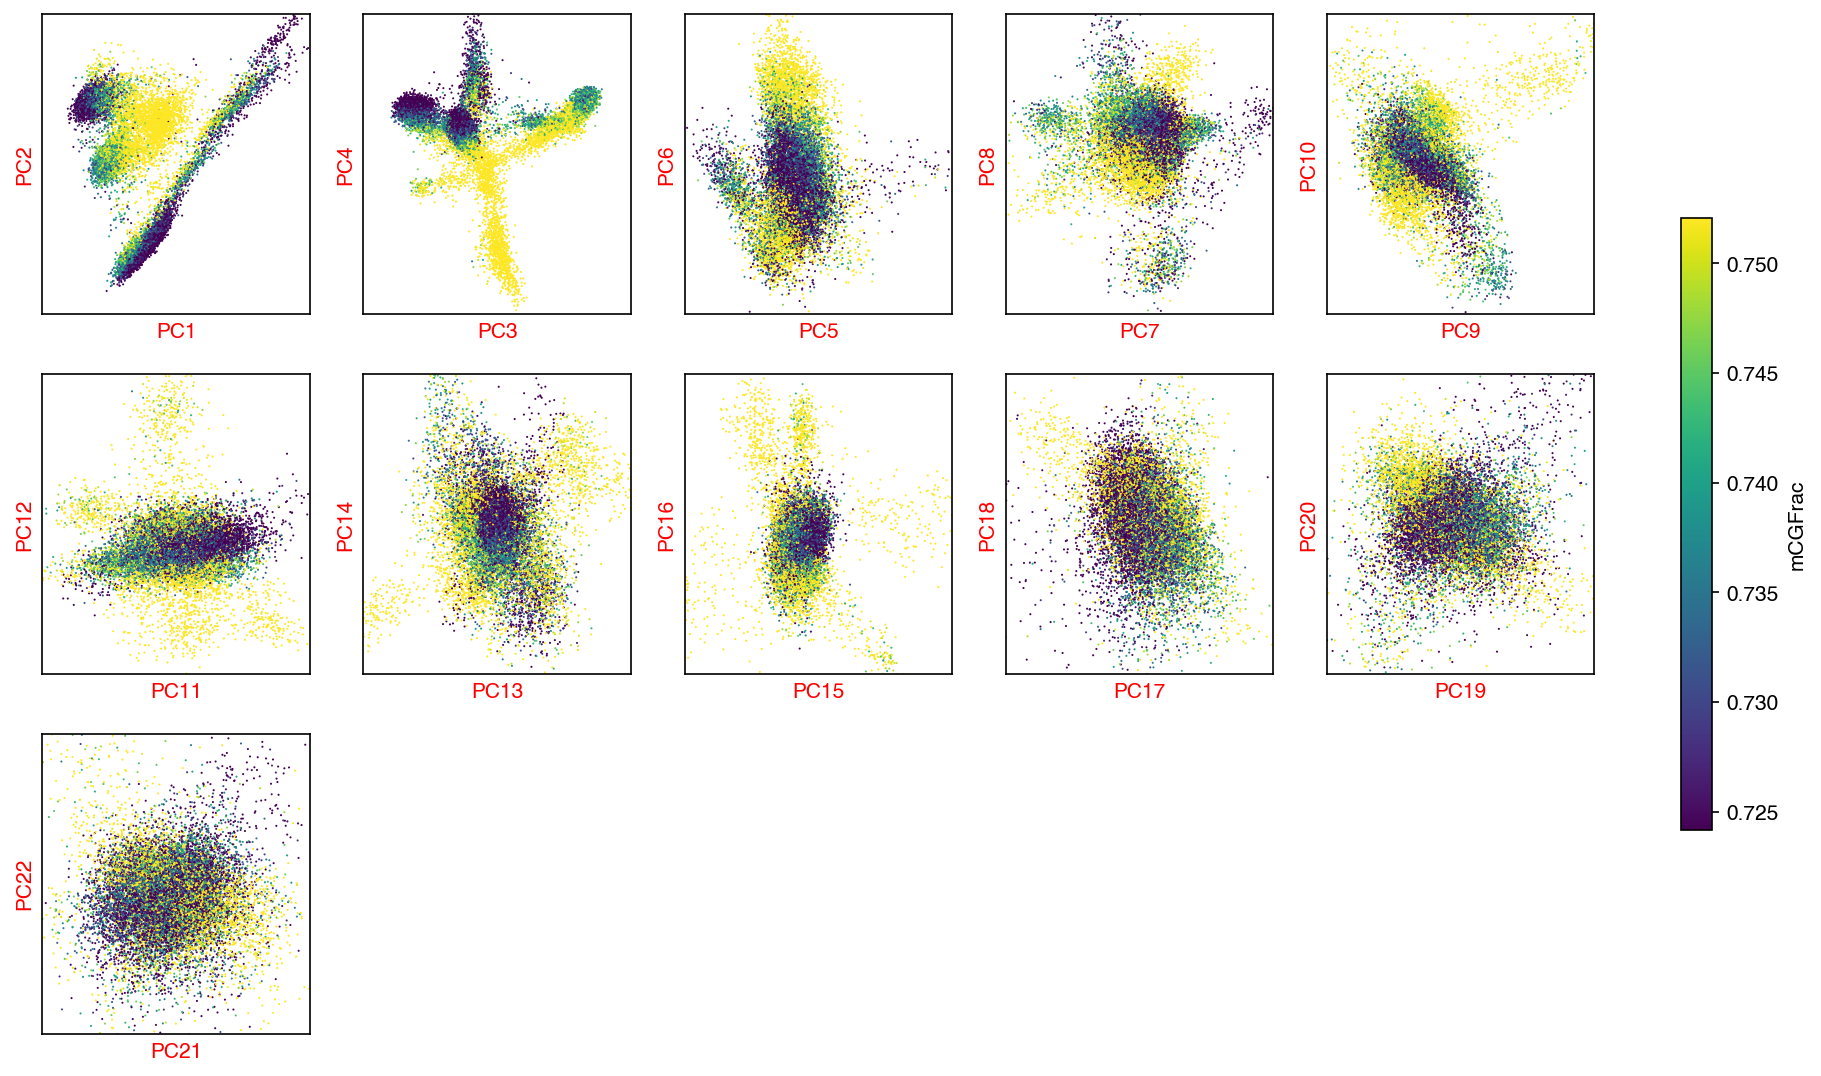

In [19]:
sc.tl.pca(mcg_adata)
cg_n_components = significant_pc_test(mcg_adata)
fig, axes = plot_decomp_scatters(mcg_adata,
                                 n_components=cg_n_components,
                                 hue=mcg_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

### Concatenate PCs

In [20]:
ch_pcs = mch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = mcg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = mch_adata.copy()
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

## Clustering

### Calculate Nearest Neighbors

In [21]:
if knn == -1:
    knn = max(15, int(np.log2(adata.shape[0])*2))
sc.pp.neighbors(adata, n_neighbors=knn)

### Leiden Clustering

In [22]:
sc.tl.leiden(adata, resolution=resolution)

## Manifold learning

In [23]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

### tSNE

In [24]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
adata = dump_embedding(adata, 'tsne')

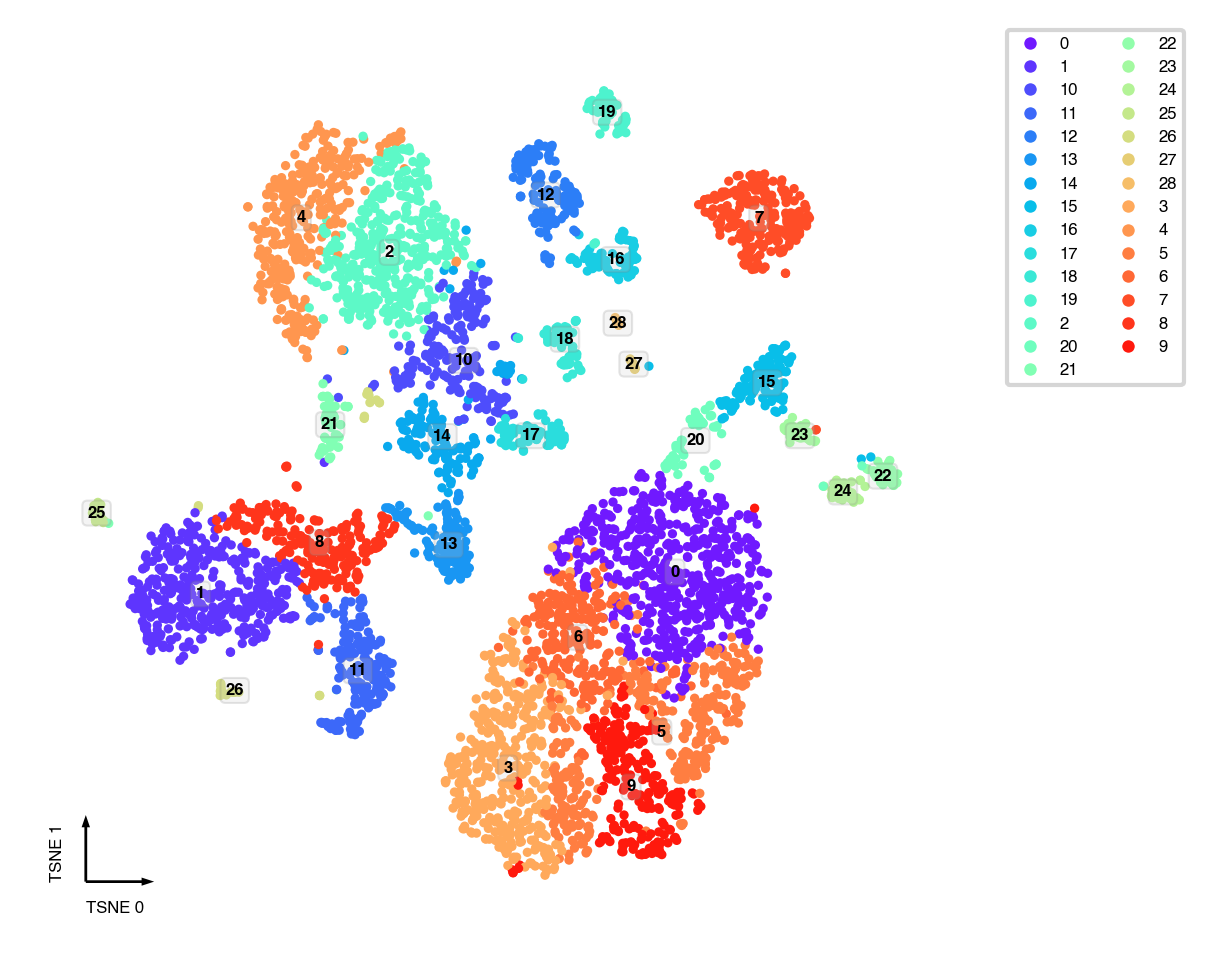

In [25]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### UMAP

In [26]:
sc.tl.umap(adata)
adata = dump_embedding(adata, 'umap')

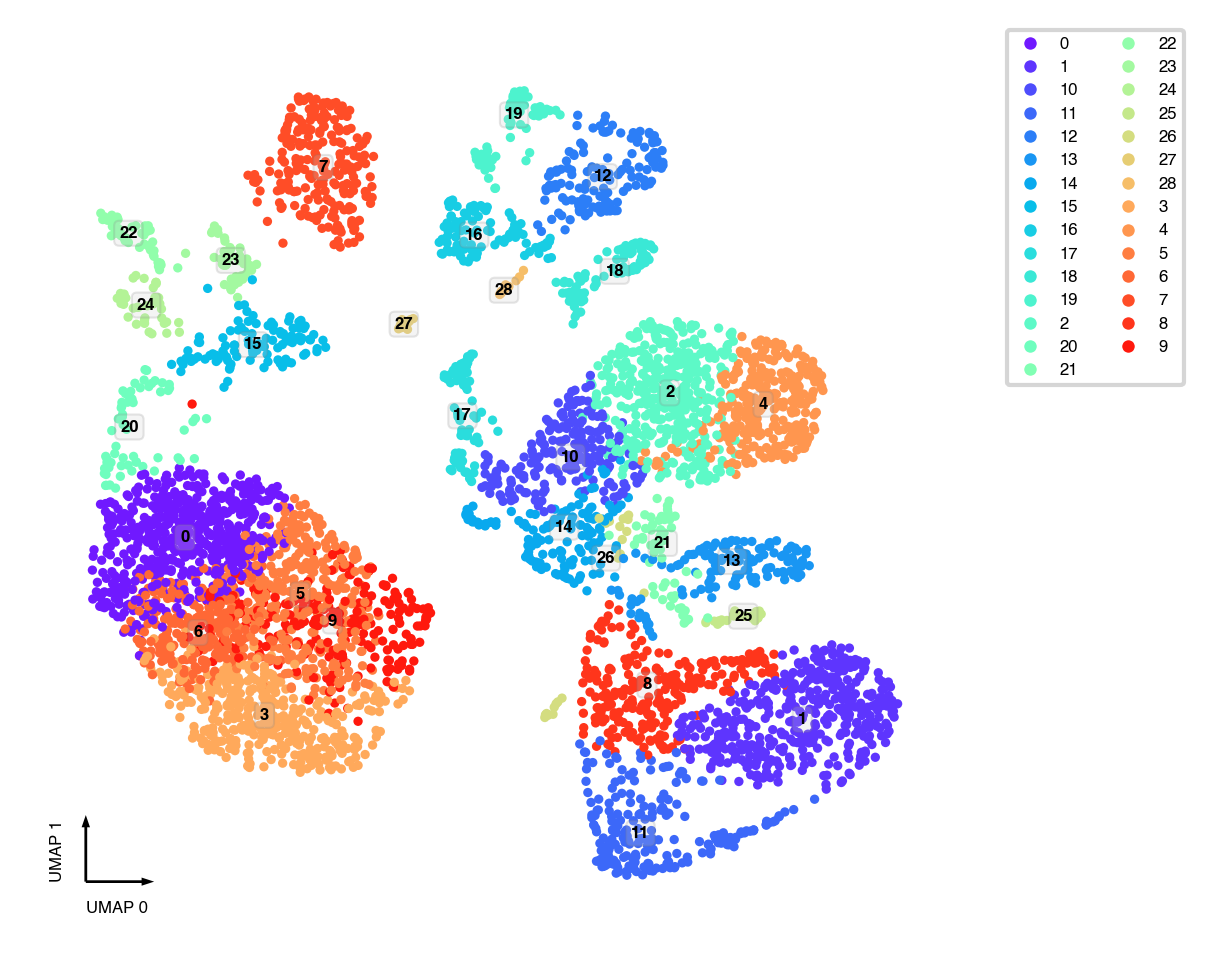

In [27]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### Interactive plot

In [28]:
# in order to reduce the page size, I downsample the data here, you don't need to do this
interactive_scatter(data=adata.obs.sample(2500),
                    hue='leiden',
                    coord_base='umap')

## Save Results

In [29]:
adata.write_h5ad('Brain.chrom100k-clustering.h5ad')
adata

... storing 'DissectionRegion' as categorical
... storing 'Plate' as categorical
... storing 'Sample' as categorical
... storing 'chrom' as categorical


AnnData object with n_obs × n_vars = 16985 × 20000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample', 'leiden', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'
    uns: 'log', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [30]:
adata.obs.to_csv('Brain.ClusteringResults.csv.gz')
adata.obs.head()

AllcPath  mCCCFrac  \
cell                                                                     
8E_M_10    /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.005505   
8E_M_100   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.004702   
8E_M_1000  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005423   
8E_M_1002  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.004117   
8E_M_1003  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005528   

            mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  InputReads  \
cell                                                                            
8E_M_10    0.744279    0.742863  0.020649    0.015228   2714916.0     6036476   
8E_M_100   0.723100    0.721792  0.012400    0.007735   3302547.0     7683706   
8E_M_1000  0.739960    0.738542  0.021733    0.016399   1369094.0     3658050   
8E_M_1002  0.745511    0.744459  0.010192    0.006101   4571390.0    11822434   
8E_M_1003  0.750461    0.749074  0.023083    0.017652   1334845.0     3479288   

           MappedReads DissectionRegion  ...  Col384  Row384 FANSDate  Slice  \
cell                                     ...                                   
8E_M_10      4014048.0               8E  ...      19       0   190711      8   
8E_M_100     5370970.0               8E  ...       1       2   190711      8   
8E_M_1000    2381916.0               8E  ...       6       5   190711      8   
8E_M_1002    8079217.0               8E  ...       7       5   190711      8   
8E_M_1003    2337068.0               8E  ...       8       4   190711      8   

              Sample  leiden     tsne_0     tsne_1     umap_0     umap_1  
cell                                                                      
8E_M_10    8E_190711       8 -43.288190   4.496988  10.774062  -5.107636  
8E_M_100   8E_190711      26 -27.657283  13.039041   9.686730   1.340617  
8E_M_1000  8E_190711       1 -58.951215 -11.439808  14.233296  -3.347982  
8E_M_1002  8E_190711       7  52.009746  41.457363   0.879984  13.307938  
8E_M_1003  8E_190711       1 -45.359897 -18.010651  11.903421  -5.233112  

[5 rows x 23 columns]

## Sanity test

In [31]:
adata.obs

AllcPath  mCCCFrac  \
cell                                                                      
8E_M_10     /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.005505   
8E_M_100    /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.004702   
8E_M_1000   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005423   
8E_M_1002   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.004117   
8E_M_1003   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005528   
...                                                       ...       ...   
11F_M_3037  /gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...  0.003731   
11F_M_3038  /gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...  0.008709   
11F_M_3039  /gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...  0.003198   
11F_M_3040  /gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...  0.005414   
11F_M_3042  /gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...  0.006548   

             mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  \
cell                                                                 
8E_M_10     0.744279    0.742863  0.020649    0.015228   2714916.0   
8E_M_100    0.723100    0.721792  0.012400    0.007735   3302547.0   
8E_M_1000   0.739960    0.738542  0.021733    0.016399   1369094.0   
8E_M_1002   0.745511    0.744459  0.010192    0.006101   4571390.0   
8E_M_1003   0.750461    0.749074  0.023083    0.017652   1334845.0   
...              ...         ...       ...         ...         ...   
11F_M_3037  0.728871    0.727856  0.008782    0.005071   2280757.0   
11F_M_3038  0.825159    0.823623  0.045721    0.037337   1968259.0   
11F_M_3039  0.716178    0.715268  0.007289    0.004104   2290136.0   
11F_M_3040  0.736058    0.734621  0.023657    0.018342   1806866.0   
11F_M_3042  0.769003    0.767481  0.031685    0.025302   1813683.0   

            InputReads  MappedReads DissectionRegion  ...  Col384  Row384  \
cell                                                  ...                   
8E_M_10        6036476    4014048.0               8E  ...      19       0   
8E_M_100       7683706    5370970.0               8E  ...       1       2   
8E_M_1000      3658050    2381916.0               8E  ...       6       5   
8E_M_1002     11822434    8079217.0               8E  ...       7       5   
8E_M_1003      3479288    2337068.0               8E  ...       8       4   
...                ...          ...              ...  ...     ...     ...   
11F_M_3037     5808520    3843064.0              11F  ...      17      14   
11F_M_3038     5149072    3327266.0              11F  ...      17      15   
11F_M_3039     5688324    3895922.0              11F  ...      16      14   
11F_M_3040     4782424    3047315.0              11F  ...      16      15   
11F_M_3042     4670214    3109325.0              11F  ...      17      15   

           FANSDate  Slice      Sample  leiden     tsne_0     tsne_1  \
cell                                                                   
8E_M_10      190711      8   8E_190711       8 -43.288190   4.496988   
8E_M_100     190711      8   8E_190711      26 -27.657283  13.039041   
8E_M_1000    190711      8   8E_190711       1 -58.951215 -11.439808   
8E_M_1002    190711      8   8E_190711       7  52.009746  41.457363   
8E_M_1003    190711      8   8E_190711       1 -45.359897 -18.010651   
...             ...    ...         ...     ...        ...        ...   
11F_M_3037   190305     11  11F_190305       5  33.254202 -43.444614   
11F_M_3038   190305     11  11F_190305      16  22.831159  38.614696   
11F_M_3039   190305     11  11F_190305       9  32.535472 -44.885823   
11F_M_3040   190305     11  11F_190305       8 -47.002925  -2.888045   
11F_M_3042   190305     11  11F_190305      17   8.536781  12.397222   

               umap_0     umap_1  
cell                              
8E_M_10     10.774062  -5.107636  
8E_M_100     9.686730   1.340617  
8E_M_1000   14.233296  -3.347982  
8E_M_1002    0.879984  13.307938  
8E_M_1003   11.90

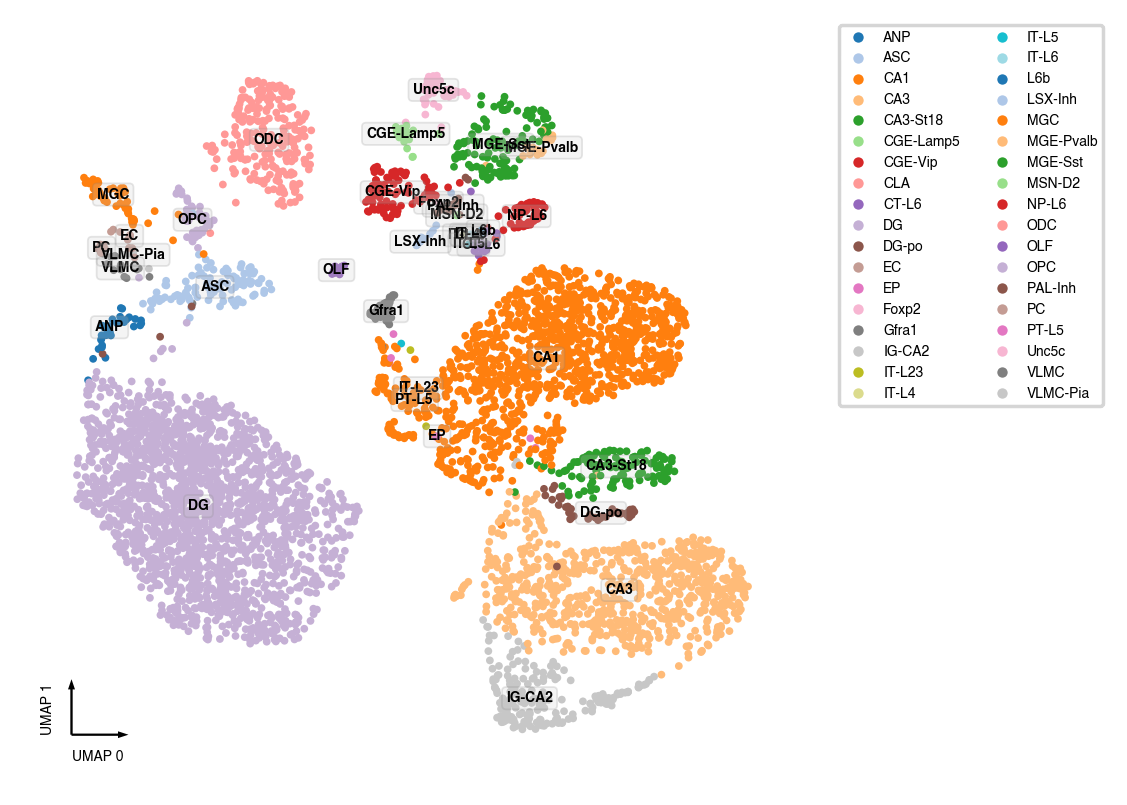

In [32]:
# This test dataset come from Liu et al. 2021 Nature, so we already annotated the cell types
# For new datasets, see following notebooks about identifying cluster markers and annotate clusters
try:
    cell_anno = pd.read_csv('../../data/Brain/snmC-seq2/HIP.Annotated.CellMetadata.csv.gz', index_col=0)
    fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
    adata.obs['CellTypeAnno'] = cell_anno['MajorType']
    adata.obs['CellTypeAnno'].fillna('nan', inplace=True)
    _ = categorical_scatter(data=adata.obs,
                            ax=ax,
                            coord_base='umap',
                            hue='CellTypeAnno',
                            text_anno='CellTypeAnno',
                            palette='tab20',
                            show_legend=True)
except BaseException:
    pass

You may notice that here is an outlier population (nan) near the IT-L4, IT-L5, IT-L6,
which is likely correspond to potential doublets.
We can identify doublets using the MethylScrublet notebook.

In [38]:
# this cell will not occur in the documentation
import subprocess
subprocess.run('rm -f Brain.ClusteringResults.csv.gz Brain.chrom100k-clustering.h5ad', shell=True)